# Imports

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import pickle 
import matplotlib.pyplot as plt

# from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.tree import plot_tree
import pandas as pd
from sklearn.feature_selection import mutual_info_classif


In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification,
                          RobertaTokenizer, RobertaForSequenceClassification, ElectraTokenizer, ElectraForSequenceClassification,
                          AutoTokenizer, AutoModelForSequenceClassification,AdamW)
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm  # For the progress bar
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Preprocessing

In [34]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
def label_mapper(label):
    # BENIGN, web_attack, ddos, botnet, infiltration, dos, ssh_bruteforce, ftp_bruteforce, others
    if label == 'Benign':
        return 0
    elif label.startswith("Brute Force"):
        return 1
    elif label.startswith("DDoS") or label.startswith("DDOS"):
        return 2
    elif label.startswith("Bot"):
        return 3
    elif label.startswith("Infilteration") :
        return 4
    elif label.startswith("DoS"):
        return 5
    elif label.startswith("SSH"):
        return 6
    elif label.startswith("FTP"):
        return 7
    elif label.startswith("SQL"):
        return 8
    else:
        return 9
    

def dataset_cleaner(df, label_column):


    
    """
    Clean the dataset by handling missing values, scaling numerical features, and 
    applying one-hot encoding to categorical features, while leaving the label class intact.
    
    Parameters:
    - df: DataFrame, the input DataFrame.
    - label_column: str, the name of the target (label) column to be preserved.
    
    Returns:
    - DataFrame with cleaned features and the label column intact.
    """   
    # Separate label column from features
    label = df[label_column]
    df = df.drop(columns=[label_column])
    
    # Drop all inf and other NaN values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)

    # Define numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # 1. Handle numerical columns (impute missing values and scale)
    if numerical_cols:
        # Imputation for numerical columns
        numerical_imputer = SimpleImputer(strategy='mean')
        df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

        # Scaling numerical columns
        scaler = StandardScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    if categorical_cols:
        # 2. Handle categorical columns (impute missing values and apply one-hot encoding)
        # Imputation for categorical columns
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

        df = pd.get_dummies(df)
        print("hot enconding done")

    # Re-add the label column
    df[label_column] = label

    return df

def get_target_features(df, test_size = 0.30):
    X = df.drop(['Label'], axis=1)
    y = df['Label']
    
    return train_test_split(X, y, test_size=test_size, random_state=42)

print("Functions defined")

Functions defined


In [35]:
def label_fix(df):
    df['Label'] = df['Attack'].apply(label_mapper)
    return df

# Feature Selection

In [36]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

def select_features_correlation(X, y, k=10):
    """
    Select top k features based on correlation with the target.

    Parameters:
    - X: DataFrame, the feature matrix.
    - y: Series, the target variable.
    - k: int, number of top features to select.

    Returns:
    - List of top k features based on correlation.
    """
    # Factorize the target and convert to pandas Series
    y_factorized = pd.Series(y.factorize()[0], index=y.index)
    
    # Convert categorical features to numeric
    X_encoded = X.apply(LabelEncoder().fit_transform)
    
    # Compute correlation
    correlation = X_encoded.corrwith(y_factorized)
    
    # Create a DataFrame for correlation values
    correlation_df = pd.DataFrame({
        'Feature': correlation.index,
        'Correlation': correlation.values
    }).sort_values(by='Correlation', key=abs, ascending=False)
    
    # Select top k features
    return correlation_df.head(k)['Feature'].tolist()

def select_features_information_gain(X, y, k=10):
    """
    Select top k features based on information gain with the target.

    Parameters:
    - X: DataFrame, the feature matrix.
    - y: Series, the target variable.
    - k: int, number of top features to select.

    Returns:
    - List of top k features based on information gain.
    """
    # Convert categorical features to numeric
    X_encoded = X.apply(LabelEncoder().fit_transform)
    
    # Calculate information gain
    info_gain = mutual_info_classif(X_encoded, y, discrete_features='auto', random_state=42)
    
    # Create a DataFrame for information gain values
    info_gain_df = pd.DataFrame({
        'Feature': X.columns,
        'Information Gain': info_gain
    }).sort_values(by='Information Gain', ascending=False)
    
    # Select top k features
    return info_gain_df.head(k)['Feature'].tolist()

def get_top_features_across_files(file_paths, label_column, k=10):
    """
    Get top k features across multiple files, based on both correlation and information gain.

    Parameters:
    - file_paths: list of file paths.
    - label_column: name of the label column.
    - k: number of top features to select.

    Returns:
    - List of top k features consistent across all files.
    """
    feature_counter = Counter()
    idx = 1

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        X = df.drop(columns=[label_column])
        y = df[label_column]
        
        # Select top features using both methods
        top_corr_features = select_features_correlation(X, y, k)
        top_ig_features = select_features_information_gain(X, y, k)
        
        # Combine and count features
        feature_counter.update(top_corr_features + top_ig_features)
        print("File "+str(idx)+" done.")
        idx = idx+1
    
    # Get most common features across files
    most_common_features = feature_counter.most_common(k)
    return [feature for feature, _ in most_common_features]

def keep_selected_features(df, selected_features, label_column):
    """
    Keep only the selected features in the given DataFrame, while leaving the label column intact.

    Parameters:
    - df: DataFrame, the input DataFrame.
    - selected_features: list of feature names to keep.
    - label_column: str, the name of the target (label) column to be preserved.

    Returns:
    - DataFrame with only the selected features and the label column.
    """
    # Extract the label column
    label = df[label_column]
    
    # Drop the label column from the selected features if it's included
    if label_column in selected_features:
        selected_features.remove(label_column)
    
    # Keep only the selected features
    updated_df = df[selected_features]
    
    # Re-add the label column
    updated_df[label_column] = label
    
    return updated_df



In [37]:
top_features = ['Attack', 'TCP_WIN_MAX_IN', 'TCP_FLAGS', 'L7_PROTO', 'MAX_IP_PKT_LEN', 'LONGEST_FLOW_PKT', 'MAX_TTL', 'MIN_TTL', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'CLIENT_TCP_FLAGS', 'PROTOCOL', 'DNS_TTL_ANSWER', 'DNS_QUERY_ID', 'MIN_IP_PKT_LEN', 'DNS_QUERY_TYPE', 'SHORTEST_FLOW_PKT', 'DURATION_OUT', 'DURATION_IN']
top_features.remove('Attack')

# Feature to Strings Convertion

In [38]:
def string_conversion(df, label_column, format_type="concatenated"):
        """
        Converts numerical data into textual representations and optionally concatenates them with labels.

        Parameters:
        df (DataFrame): The input DataFrame containing features and labels.
        label_column (str): The name of the label column.
        format_type (str): The format for conversion. Options:
                        - "concatenated": Concatenate feature values with underscores.
                        - "key_value": Convert feature-value pairs into text (e.g., feature1: 23.5).

        Returns:
        DataFrame: A DataFrame with transformed features and labels.
        """
        # Select non-label columns
        non_label_columns = df.drop(columns=[label_column]).columns

        if format_type == "concatenated":
            # Convert numerical values to strings and concatenate them with underscores
            df['transformed'] = df[non_label_columns].astype(str).apply(lambda row: '_'.join(row), axis=1)

        elif format_type == "key_value":
            # Convert each feature-value pair into key-value text
            df['transformed'] = df[non_label_columns].apply(
                lambda row: ' '.join([f"{col}: {row[col]}" for col in non_label_columns]), axis=1
            )

        else:
            raise ValueError("Invalid format_type. Choose either 'concatenated' or 'key_value'.")

        # Add the label column to the result
        relevant_columns = ['transformed', label_column]
        updated_df = df[relevant_columns]

        return updated_df
    

# Dataset Load & Label Encoding

In [39]:
df = pd.read_csv('dataset/downsampled/final_downsampled_dataset.csv')   

print(f"LOADED FILE , STARTING CLEANUP\n")

#df =label_fix(df)
df.rename(columns={'Attack': 'Label'}, inplace=True)


#df = keep_selected_features(df,top_features,"Label")
    
df = dataset_cleaner(df,"Label")

#df = string_conversion(df,"Label","concatenated")  
df = string_conversion(df,"Label","key_value")
print(df.head())  
 
print(f"CLEANUP DONE, STARTING SPLIT\n")

LOADED FILE , STARTING CLEANUP

                                         transformed  Label
0  TCP_WIN_MAX_IN: -0.5945997975478896 TCP_FLAGS:...      0
1  TCP_WIN_MAX_IN: -0.15685586920893607 TCP_FLAGS...      0
2  TCP_WIN_MAX_IN: -0.5945997975478896 TCP_FLAGS:...      0
3  TCP_WIN_MAX_IN: -0.5945997975478896 TCP_FLAGS:...      0
4  TCP_WIN_MAX_IN: -0.15685586920893607 TCP_FLAGS...      0
CLEANUP DONE, STARTING SPLIT



In [40]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Label'])

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['transformed'], df['label_encoded'], test_size=0.3, random_state=42
)

# Model Selection & Load

In [41]:
# Define model configuration
def load_model_and_tokenizer(model_name, num_classes):
    if model_name == "bert":
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
    elif model_name == "distilbert":
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)
    elif model_name == "roberta":
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_classes)
    elif model_name == "electra":
        tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
        model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=num_classes)
    elif model_name == "spanbert":
        tokenizer = AutoTokenizer.from_pretrained('SpanBERT/spanbert-base-cased')
        model = AutoModelForSequenceClassification.from_pretrained('SpanBERT/spanbert-base-cased', num_labels=num_classes)
    elif model_name == "codebert":
        tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
        model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=num_classes)
    elif model_name == "gpt2":
        # Load GPT-2 tokenizer and add padding token
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        tokenizer.pad_token = tokenizer.eos_token  # Use the EOS token as the padding token 
        model = GPT2ForSequenceClassification.from_pretrained(
            "gpt2", 
            num_labels=num_classes)
        model.config.pad_token_id = tokenizer.pad_token_id
    elif model_name == "gpt-neo":
        tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-1.3B')
        model = AutoModelForSequenceClassification.from_pretrained('EleutherAI/gpt-neo-1.3B', num_labels=num_classes)
    elif model_name == "gpt-j":
        tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-j-6B')
        model = AutoModelForSequenceClassification.from_pretrained('EleutherAI/gpt-j-6B', num_labels=num_classes)
    elif model_name == "opt":
        tokenizer = AutoTokenizer.from_pretrained('facebook/opt-350m')
        model = AutoModelForSequenceClassification.from_pretrained('facebook/opt-350m', num_labels=num_classes)
    else:
        raise ValueError("Unsupported model name. Choose from: bert, distilbert, roberta, electra, spanbert, codebert, gpt2, gpt-neo, gpt-j, opt")

    return tokenizer, model


In [42]:
# Example usage
model_name = "bert" #Change this to select different models: bert, distilbert, roberta, electra, spanbert, codebert
num_classes = len(label_encoder.classes_)
tokenizer, model = load_model_and_tokenizer(model_name, num_classes)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Custom Dataset

In [43]:


# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [44]:
# Create datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)



# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)
print(num_classes)
print(label_encoder.classes_)


9
[0 1 2 3 4 5 6 7 8]


c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training

In [45]:
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Initialize the tqdm progress bar
    progress_bar = tqdm(data_loader, desc="Training", total=len(data_loader))

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the loss and accuracy
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar with the loss
        progress_bar.set_postfix(loss=total_loss / (total + len(labels)), accuracy=correct / total)

    # Return average loss and accuracy
    return total_loss / len(data_loader), correct / total

# Conf_Matrix

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(all_labels, all_preds, save_path=None, title=None):
    """
    Generates and plots the confusion matrix using the classes from all_labels and all_preds.
    Optionally, adds a title and saves the plot to the specified file path.

    Parameters:
    - all_labels: list of true labels
    - all_preds: list of predicted labels
    - save_path: str (optional) path to save the confusion matrix plot (e.g., 'confusion_matrix.png')
    - title: str (optional) title for the plot
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    unique_labels = list(set(all_labels))

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    disp.plot(cmap="Blues", xticks_rotation='vertical')

    # Add title if provided
    if title:
        plt.title(title)

    # If a save path is provided, save the plot
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    else:
        plt.show()  # If no save path, show the plot instead

    plt.close()  # Close the plot to avoid memory issues if running multiple times
    
    return cm



# Evaluation

In [47]:
def evaluate_model(model, data_loader, device, label_encoder,epoch,model_name):
    model = model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Initialize the tqdm progress bar
    progress_bar = tqdm(data_loader, desc="Evaluating", total=len(data_loader))

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Append labels and predictions as lists
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

            # Update the progress bar with the current loss and accuracy
            progress_bar.set_postfix(loss=total_loss / (total + len(labels)), accuracy=correct / total)

    # Ensure all_preds and all_labels are iterable
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Plot the confusion matrix using classes from all_labels and all_preds
    cm_title = model_name + "_epoch_" + str(epoch)
    cm = plot_confusion_matrix(all_labels, all_preds,title=cm_title)

    # Calculate metrics directly
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, labels=np.unique(all_labels))
    recall = recall_score(all_labels, all_preds, average=None, labels=np.unique(all_labels))
    f1 = f1_score(all_labels, all_preds, average=None, labels=np.unique(all_labels))

    # You can calculate overall or per-class metrics
    overall_precision = np.mean(precision)
    overall_recall = np.mean(recall)
    overall_f1 = np.mean(f1)

    # Prepare metrics
    metrics = {
        "accuracy": accuracy,
        "overall_precision": overall_precision,
        "overall_recall": overall_recall,
        "overall_f1": overall_f1
    }

    # Return total loss, accuracy, and metrics
    return total_loss / len(data_loader), correct / total, metrics

In [48]:

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


KeyboardInterrupt: 

# Main

Evaluating: 100%|██████████| 725/725 [00:56<00:00, 12.87it/s, accuracy=0.957, loss=0.0104]


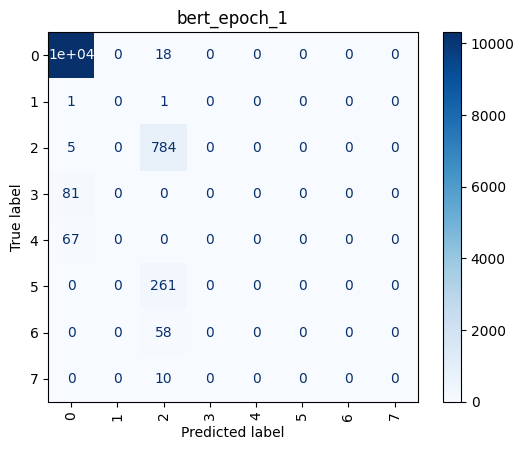

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/3
Train Loss: 0.2091, Train Accuracy: 0.9464
Validation Loss: 0.1670, Validation Accuracy: 0.9567
{'accuracy': 0.9567092100724388, 'overall_precision': 0.2097327974897613, 'overall_recall': 0.24899000367170987, 'overall_f1': 0.22599614104972499}


Training:  21%|██        | 357/1691 [01:11<04:27,  4.99it/s, accuracy=0.955, loss=0.0112] 


KeyboardInterrupt: 

In [31]:
epochs = 3

# Variables to store overall metrics across all epochs
total_val_loss = 0
total_val_acc = 0
total_precision = 0
total_recall = 0
total_f1 = 0

for epoch in range(epochs):
    
    # Train for each epoch
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    
    # Evaluate on the validation set for each epoch
    val_loss, val_acc, val_metrics = evaluate_model(model, val_loader, device, label_encoder,(epoch+1),model_name)
    
    # Print per-epoch results
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(val_metrics)
    
    # Accumulate validation metrics across all epochs for later averaging
    total_val_loss += val_loss
    total_val_acc += val_acc
    total_precision += val_metrics['overall_precision']
    total_recall += val_metrics['overall_recall']
    total_f1 += val_metrics['overall_f1']

# Calculate and print overall mean metrics
mean_val_loss = total_val_loss / epochs
mean_val_acc = total_val_acc / epochs
mean_precision = total_precision / epochs
mean_recall = total_recall / epochs
mean_f1 = total_f1 / epochs

print("\nOverall Validation Results:")
print(f"Mean Validation Loss: {mean_val_loss:.4f}")
print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

Evaluating: 100%|██████████| 725/725 [00:56<00:00, 12.87it/s, accuracy=0.957, loss=0.0104]


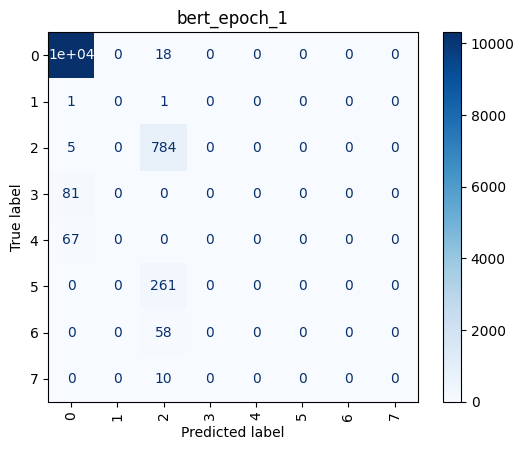

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/3
Train Loss: 0.2091, Train Accuracy: 0.9464
Validation Loss: 0.1670, Validation Accuracy: 0.9567
{'accuracy': 0.9567092100724388, 'overall_precision': 0.2097327974897613, 'overall_recall': 0.24899000367170987, 'overall_f1': 0.22599614104972499}


Training:  21%|██        | 357/1691 [01:11<04:27,  4.99it/s, accuracy=0.955, loss=0.0112] 


KeyboardInterrupt: 

In [ ]:
epochs = 3

# Variables to store overall metrics across all epochs
total_val_loss = 0
total_val_acc = 0
total_precision = 0
total_recall = 0
total_f1 = 0

for epoch in range(epochs):
    
    # Train for each epoch
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    
    # Evaluate on the validation set for each epoch
    val_loss, val_acc, val_metrics = evaluate_model(model, val_loader, device, label_encoder,(epoch+1),model_name)
    
    # Print per-epoch results
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(val_metrics)
    
    # Accumulate validation metrics across all epochs for later averaging
    total_val_loss += val_loss
    total_val_acc += val_acc
    total_precision += val_metrics['overall_precision']
    total_recall += val_metrics['overall_recall']
    total_f1 += val_metrics['overall_f1']

# Calculate and print overall mean metrics
mean_val_loss = total_val_loss / epochs
mean_val_acc = total_val_acc / epochs
mean_precision = total_precision / epochs
mean_recall = total_recall / epochs
mean_f1 = total_f1 / epochs

print("\nOverall Validation Results:")
print(f"Mean Validation Loss: {mean_val_loss:.4f}")
print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")